# Setting Up the Notebook:

This notebook requires `Pillow` which is a fork of `PIL`.  To install this module run the cell below:

In [ ]:
import sys
prefix = '\"%s\"' %  sys.prefix
!conda install --yes --prefix {prefix} pillow

# About Item Thumbnails

A thumbnail image is created by default when you add the item to the site. It appears in galleries, search results, contents, and the item page. You can create and load a different image if the default image does not convey the information you want.

In ArcGIS Online, you can drag an image or browse to a file. For best results, add an image that is 600 pixels wide by 400 pixels high or larger with an aspect ratio of 1.5:1 in a web file format such as PNG, JPEG, or GIF. Pan and zoom to what you want to appear in your thumbnail. Depending on the size and resolution of your image file and how far you zoom in to customize the thumbnail, the image may be resampled and scaled when it's saved. If you add an image in GIF or JPEG format, it will be converted to PNG when it's saved.

## Finding Missing and Invalid Images

This notebook shows how a user can find images under the 600x400 pixel size for a given user.

In [1]:
import os
import io
import base64
import shutil
from getpass import getpass

In [2]:
import pandas as pd
from PIL import Image
from IPython.display import HTML
import ipywidgets as widgets
from arcgis.gis import GIS, Item, User

pd.set_option('display.max_colwidth', -1)

### Connect to the GIS

Use the login credentials to your site to populate the interactive application below.

In [3]:
username = getpass()
password = getpass()

········
········


In [4]:
gis = GIS(username=username, password=password, verify_cert=False)

In [12]:
def get_images(username, gis, min_width=600, min_height=400, show_image=True):
    """
    Finds all images for a given user under a specific image size in pixels.
    
    ================   ===========================================
    **Inputs**         **Description**
    ----------------   -------------------------------------------
    username           Required string. The name of the user items 
                       to exmine.
    ----------------   -------------------------------------------
    gis                Required GIS. The connection to Portal/AGOL
    ----------------   -------------------------------------------
    min_height         Optional Integer. The height in pixels of 
                       the image. Any image below this height will 
                       be returned in the dataframe.
    ----------------   -------------------------------------------
    min_width          Optional Integer. The width of the image. 
                       Anything below this width will be returned.
    ----------------   -------------------------------------------
    show_image         Optional boolean. If True, the results will 
                       be returned as an HTML table. Else, they 
                       will be returned as a pandas DataFrame.
    ================   ===========================================
    
    returns: string or pd.DataFrame
    
    """
    results = []
    show_image_columns=['title', 'username','folder', 'item_id', 'item_thumbnail','width', 'height']
    no_show_image_columns=['title', 'username','folder', 'item_id', 'width', 'height']
    user = gis.users.get(username)
    username = user.username
    folders = [fld['title'] for fld in user.folders] + [None]
    for folder in folders:
        items = user.items(folder=folder, max_items=1000)
        for item in items:
            thumbnail = item.thumbnail
            if show_image:
                if thumbnail:
                    bn = os.path.basename(thumbnail)
                    image_bytes = item.get_thumbnail()
                    img = Image.open(io.BytesIO(image_bytes))
                    b64_item = base64.b64encode(image_bytes)
                    b64thmb = "data:image/png;base64," + str(b64_item,"utf-8") + "' width='200' height='133"
                    item_thumbnail = """<img src='""" + str(b64thmb) + """' class="itemThumbnail">"""
                    results.append([item.title, username, folder, item.id, item_thumbnail] + list(img.size))
                    img.close()
                    del img
                else:
                    results.append([item.title, username, folder, item.id, "", -999,-999])
            else:
                if thumbnail:
                    image_bytes = item.get_thumbnail()
                    img = Image.open(io.BytesIO(image_bytes))
                    results.append([item.title, username, folder, item.id] + list(img.size))
                    img.close()
                    del img
                else:
                    results.append([item.title, username, folder, item.id,None,None])
    
    if show_image:
        df = pd.DataFrame(results, columns=show_image_columns)
        q = (df.width <= float(min_width)) | (df.height < float(min_height)) | (df.height.isnull()) | (df.width.isnull())
        df = (df[q]
              .copy()
              .reset_index(drop=True))
        return HTML(df.to_html(escape=False))
    else:
        df = pd.DataFrame(results, columns=no_show_image_columns)
        q = (df.width <= float(min_width)) | (df.height < float(min_height)) | (df.height.isnull()) | (df.width.isnull())
        df = (df[q]
              .copy()
             .reset_index(drop=True))
        return df

# Usage

To get a DataFrame that can be queried, set `show_image` to `False`.  This will return an object that can be further used for analysis.  The dataframe reports back the width/height of the image.  If an image is missing, the value will be **NaN** for width/height.  

### Example: Retrieve All Thumbnails Under 400x300

In [18]:
username = "geodev0"
df = get_images(username, gis=gis, 
                min_height=300, min_width=400, 
                show_image=False)
df

,title,username,folder,item_id,width,height
0,four_five_month,geodev0,None,a416597cdf88422db321b8e29708745f,200,133


## Item Thumbnails Back as HTML Report

Sometimes just creating a table to see what is there is good enough.  By setting `show_image` to `True`, the method allows for a quick visualization approach to the thumbnail problem.  

### Example: Find all Images Under 600x400 Pixels:

,title,username,folder,item_id,item_thumbnail,width,height
0,four_five_month,geodev0,None,a416597cdf88422db321b8e29708745f,,200,133

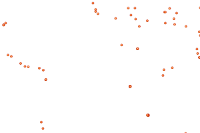

In [19]:
df = get_images(username, gis=gis, 
                show_image=True)
df